In [4]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
import sys

from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('poster',font_scale=1)

In [5]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,AUC = True,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        
        
        #Round predicted values for Regression model
#         if model_name == 'Random Forest Regressor':
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        if AUC:
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    fpr, tpr, thresh = roc_curve(yt,ys)
                    tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                    tprs.append(tpr)

                tpr = sum(tprs)
                fpr = fpr_mean
                
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])

            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
                
            RMS_all.append(auroc)
            
        else:

            RMS=0
            for yp,yt in zip(ypred,y):
                RMS += ((yp - yt)**2)
            RMS = RMS / len(y)
            RMS = math.sqrt(RMS)

            RMS_all.append(RMS)

        groupres[model_name] = {'RMS':RMS_all, 'tpr': tpr_all, 'fpr':fpr_all}

        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [21]:
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

featdict = {'freq':['Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew','PSD_kur'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean','jerk_std','jerk_skew','jerk_kur'],
            'mag' :['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag']}


#Accel+Gyro file has features labeled with 'acc' and 'gyr' 
def fix_feature_names(features):
    feats = features.copy()
    if feats[0][-3:] != 'acc':
        featlen = len(feats)
        for f in range(featlen):
            feats.append(feats[f] + ' gyr')
        for f in range(featlen):
            feats[f] = feats[f] + ' acc'
    return feats

featdictsensors = {}

for featgroup in featdict.keys():
    feats = fix_feature_names(featdict[featgroup])
    featdictsensors[featgroup] = feats

In [7]:
lst = featdict.keys()
combs = []
for i in range(len(lst)):
    els = [list(x) for x in combinations(lst, i+1)]
    combs.extend(els)

combs

[['freq'],
 ['time'],
 ['corr'],
 ['jerk'],
 ['mag'],
 ['freq', 'time'],
 ['freq', 'corr'],
 ['freq', 'jerk'],
 ['freq', 'mag'],
 ['time', 'corr'],
 ['time', 'jerk'],
 ['time', 'mag'],
 ['corr', 'jerk'],
 ['corr', 'mag'],
 ['jerk', 'mag'],
 ['freq', 'time', 'corr'],
 ['freq', 'time', 'jerk'],
 ['freq', 'time', 'mag'],
 ['freq', 'corr', 'jerk'],
 ['freq', 'corr', 'mag'],
 ['freq', 'jerk', 'mag'],
 ['time', 'corr', 'jerk'],
 ['time', 'corr', 'mag'],
 ['time', 'jerk', 'mag'],
 ['corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk'],
 ['freq', 'time', 'corr', 'mag'],
 ['freq', 'time', 'jerk', 'mag'],
 ['freq', 'corr', 'jerk', 'mag'],
 ['time', 'corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk', 'mag']]

In [36]:
datadict = {'watch':{'Tremor':{},'Bradykinesia':{}},'sensor':{'Tremor':{},'Bradykinesia':{}}}
datadict['watch']['Tremor']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 40Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['watch']['Bradykinesia']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 5Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Tremor']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Bradykinesia']['Binary'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel+Gyro Data 20Hz.csv',index_col=0)#.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'])
datadict['watch']['Tremor']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 20Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['watch']['Bradykinesia']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 5Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Tremor']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'])
datadict['sensor']['Bradykinesia']['Multiclass'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel+Gyro Data 30Hz.csv',index_col=0)#.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'])

In [34]:
datadict['watch']['Tremor']['Multiclass']

Subject              Visit   Task  Bradykinesia  Tremor      RMSX  \
0      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.001075   
1      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.001588   
2      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.004131   
3      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.005020   
4      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.003293   
5      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000916   
6      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000955   
7      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000622   
8      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000465   
9      1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000298   
10     1004    2 Weeks: Time 0  Stndg           NaN     0.0  0.000278   
0      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000709   
1      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000896   
2      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000674   
3      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000456   
4      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000467   
5      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000407   
6      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000338   
7      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000284   
8      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000255   
9      1004   2 Weeks: Time 30  Stndg           NaN     0.0  0.000232   
0      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000728   
1      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000500   
2      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000292   
3      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000355   
4      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000306   
5      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000268   
6      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000470   
7      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000510   
8      1004   2 Weeks: Time 60  Stndg           NaN     0.0  0.000384   
..      ...                ...    ...           ...     ...       ...   
12     1051   2 Weeks: Time 90  Sitng           NaN     0.0  0.000276   
0      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000780   
1      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000295   
2      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000817   
3      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.001443   
4      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.001457   
5      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000955   
6      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000495   
7      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000631   
8      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.003391   
9      1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.003395   
10     1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000149   
11     1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000245   
12     1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000252   
13     1051  2 Weeks: Time 120  Sitng           NaN     0.0  0.000141   
0      1051  2 Weeks: Time 150  Sitng           NaN     0.0  0.004923   
1      1051  2 Weeks: Time 150  Sitng           NaN     0.0  0.000245   
2      1051  2 Weeks: Time 150  Sitng           NaN     0.0  0.000287   
3      1051  2 Weeks: Time 150  Sitng           NaN     0.0  0.000303   
4      1051  2 Weeks: Time 150  Sitng           NaN     0.0  0.000286   
0      1051            4 Weeks  Sitng           NaN     0.0  0.000935   
1      1051            4 Weeks  Sitng           NaN     0.0  0.000466   
2      1051            4 Weeks  Sitng           NaN     0.0  0

In [33]:
DataMulti

Subject              Visit   Task  Bradykinesia        Tremor  \
0         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
1         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
2         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
3         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
4         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
5         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
6         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
7         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
8         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
9         1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
10        1004    2 Weeks: Time 0  Stndg           NaN  3.402823e+38   
11        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
12        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
13        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
14        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
15        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
16        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
17        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
18        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
19        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
20        1004   2 Weeks: Time 30  Stndg           NaN  3.402823e+38   
21        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
22        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
23        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
24        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
25        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
26        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
27        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
28        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
29        1004   2 Weeks: Time 60  Stndg           NaN  3.402823e+38   
...        ...                ...    ...           ...           ...   
14313     1051   2 Weeks: Time 90  Sitng           NaN  3.402823e+38   
14314     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14315     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14316     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14317     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14318     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14319     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14320     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14321     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14322     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14323     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14324     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14325     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14326     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14327     1051  2 Weeks: Time 120  Sitng           NaN  3.402823e+38   
14328     1051  2 Weeks: Time 150  Sitng           NaN  3.402823e+38   
14329     1051  2 Weeks: Time 150  Sitng           NaN  3.402823e+38   
14330     1051  2 Weeks: Time 150  Sitng           NaN  3.402823e+38   
14331     1051  2 Weeks: Time 150  Sitng           NaN  3.402823e+38   
14332     1051  2 Weeks: Time 150  Sitng           NaN  3.402823e+38   
14333     1051            4 Weeks  Sitng           NaN  3.402823e+38   
14334     1051            4 Weeks  Sitng           NaN  3.402823e+38   
14335     1051            4 Weeks  Sitng           NaN  3.402823e+38   
14336     1051            4 Weeks  Sitng       

In [58]:
#skip this cell and open pkl file

t1 = time.time()
# results = {}

# for mode in ['watch','sensor']:
for mode in ['sensor']:
    
#     results[mode] = {}
    
#     for symptom in ['Tremor','Bradykinesia']:
    for symptom in ['Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)

        results[mode][symptom] = {}

        dataBin = datadict[mode][symptom]['Binary']
        dataMulti = datadict[mode][symptom]['Multiclass']

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = {}

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = {}

        for comb in combs:

            count += 1
            print('Combination %d of %d'%(count,len(combs)))
            
            feat_cols = []
            comb_group = ''

            for features_set in comb:

                comb_group += features_set[0]
                if mode == 'sensor' and symptom == 'Bradykinesia':
                    feat_cols = feat_cols + featdictsensors[features_set]
                else:
                    feat_cols = feat_cols + featdict[features_set]

            DataBin = dataBin[info + feat_cols].copy()
            DataMulti = dataMulti[info + feat_cols].copy()

            DataBin=DataBin[~DataBin[symptom].isnull()] #remove nan rows for current symptom
            for s in DataBin.columns.values[5:]:
                DataBin.loc[DataBin[s]>np.finfo(np.float32).max,s] = 100
            DataBin=DataBin.reset_index(drop=True) #reset index
            DataMulti=DataMulti[~DataMulti[symptom].isnull()] #remove nan rows for current symptom
            for s in DataMulti.columns.values[5:]:
                DataMulti.loc[DataMulti[s]>np.finfo(np.float32).max,s] = 100
            DataMulti=DataMulti.reset_index(drop=True) #reset index

            #Binary

            X = DataBin.iloc[:,5:].values
            groups = DataBin.Subject.values
            fnames = DataBin.iloc[:,5:].columns.values
            
            y = ((DataBin[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(DataBin,X,y,groups,model)
            res['Combination'] = comb_group
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups[comb_group] = res_group

            #Multiple Classes
            
            X = DataMulti.iloc[:,5:].values
            groups = DataMulti.Subject.values
            fnames = DataMulti.iloc[:,5:].columns.values

            y = DataMulti[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(DataMulti,X,y,groups,model,True)
            res['Combination'] = comb_group
            multi_res_groups[comb_group] = res_group
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[comb_group][model_name[0]]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Combination'] = [comb_group]
            multi_res_all = pd.concat([multi_res_all,R])

#             #Regressor

#             y = Data[symptom].values.astype(int) #target 

#             model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
#             model_name = ['Random Forest Regressor']
#             model = list(zip(model,model_name))

#             res,res_group = LOSOMultiClass(Data,X,y,groups,model,False)
#             res['Combination'] = comb_group
#             regress_res_groups = pd.concat((regress_res_groups,res))
#             R = pd.DataFrame()
#             R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups.Combination==comb_group]['RMS'])]
#             R['Model'] = ['Random Forest'] 
#             R['Combination'] = [comb_group]
#             regress_res_all = pd.concat([regress_res_all,R])

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

#         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
#         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\FeaturesAnalysisResults','wb')
pickle.dump(results,f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))

sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Training Random Forest
Traini

In [30]:
y

array([-2147483648, -2147483648, -2147483648, ..., -2147483648,
       -2147483648, -2147483648])

In [28]:
res_group

{}

In [27]:
multi_res_groups

{'f': {}}

In [12]:
#Open results as pickle file

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\FeaturesAnalysisResults','rb')
results = pickle.load(f)
f.close()

In [38]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [138]:
def ForwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = [(0, (1, 10)), ':', '-.', '--', '-']
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    lw=5
    plt.figure(figsize=(12,9))
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = ''
    if classifier == 'Regressor':
        current_auc = sys.maxsize
    else:
        current_auc = 0
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    plotInd = 0
            
    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if len(g)==n and all([(o in g) for o in opt_feat]) and 'm' not in g]
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])
        
        if classifier == 'Regressor':
            auc_groups = auc_groups*-1

        if CIBound:
            options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]-(CIZ*auc_sem[i])>0]
            options = []
            if len(options)>0:
                opt_ind = max(options)[1]
            else:
                opt_ind = np.argmax([auc_groups[i] for i in range(len(auc_groups))])
            gate = auc_groups[opt_ind]-(CIZ*auc_sem[opt_ind])>0
            print(auc_groups,auc_groups-CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        opt_feat = n_groups[opt_ind]
            
#         if gate:
        current_auc = AUC[opt_feat].values
        print(opt_feat,np.nanmean(current_auc))
#         else:
#             done = True

        ax = plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
                      data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
                      plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        plotInd+=1
        
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
#     plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\FeaturesForward\\' + mode + '-' + symptom + '-' + classifier + '.svg')

In [139]:
def BackwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = ['-', '--', '-.', ':', (0, (1, 10))]
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    lw=5
    plt.figure(figsize=(12,9))
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = 'ftcj'
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    current_auc = AUC[opt_feat]
      
    plotInd = 0
        
    ax = plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
             data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
             plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        
    while not done:
        n = len(opt_feat)-1
        n_groups = [g for g in groups if len(g)==n and all([(g_char in opt_feat) for g_char in g])]
        print(n_groups)
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])

        if CIBound:
#             options = [(auc_groups[i],i) for i in range(len(auc_groups)) if auc_groups[i]+(CIZ*auc_sem[i])>0]
            options = []
            if len(options)>0:
                opt_ind = max(options)[1]
            else:
                opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]+(CIZ*auc_sem[opt_ind])>0
            print(auc_groups,auc_groups+CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        opt_feat = n_groups[opt_ind]
            
        if gate:
            if auc_groups[opt_ind]>0:
                current_auc = AUC[opt_feat].values
            print(opt_feat,np.nanmean(current_auc))
        else:
            done = True
        
        plotInd+=1
        
        plot_roc(np.vstack([d for d in data[opt_feat]['Random Forest']['tpr'] if len(d)>0]),
                 data[opt_feat]['Random Forest']['fpr'][0],np.nanmean(AUC[opt_feat].values),
                 plotname=opt_feat,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
#     plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\FeaturesBackward\\' + mode + '-' + symptom + '-' + classifier + '.svg')

[0.64957234 0.68862888 0.68140368 0.65012632] [0.57808268 0.55947895 0.58922458 0.58974448]
t 0.6886288807338461


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.01209253 0.01790419 0.03367217] [-0.01774226 -0.00246601 -0.00558699]
tj 0.7223010489928081
[0.00032339 0.00610393] [-0.00915627 -0.00532027]
tcj 0.7284049824472363
[-0.00358308] [-0.01340444]
ftcj 0.7248219046917826


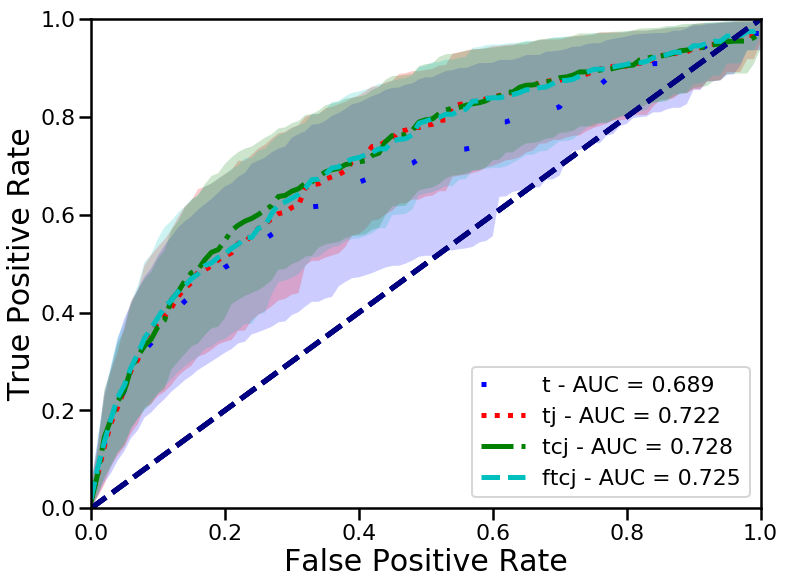

In [140]:
ForwardSelection('watch','Tremor','Binary',True,1.98)

[0.62774494 0.67552768 0.65227923 0.61260449] [0.57243183 0.56948889 0.57655004 0.56720479]
t 0.6755276837155417


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.00985439 0.0020972  0.01109468] [-0.00061978 -0.00465805  0.00351634]
tj 0.6866223672398841
[-0.01307603  0.00392944] [-0.03477393 -0.00465708]
tcj 0.6905518077669833
[-0.01166682] [-0.02810391]
ftcj 0.6788849875721442


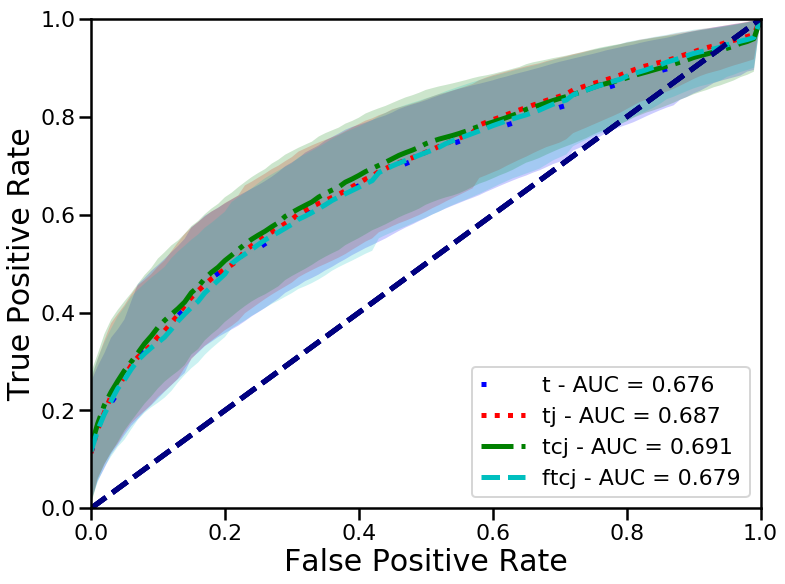

In [141]:
ForwardSelection('watch','Tremor','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[-0.01617783 -0.00219746  0.01431077  0.00358308] [-0.00533403  0.00762054  0.06161755  0.01340444]
fcj 0.739132677951225
['fc', 'fj', 'cj']
[-0.06383802 -0.02097185 -0.00905571] [-0.02445624  0.00879256  0.00407915]
cj 0.739132677951225
['c', 'j']
[-0.057729   -0.08900636] [-0.03025251 -0.03977401]


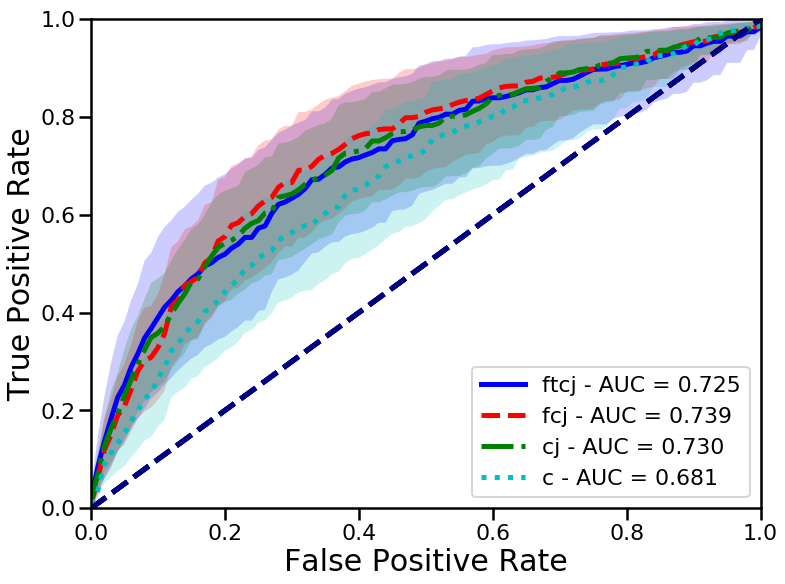

In [142]:
BackwardSelection('watch','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[ 0.00247302 -0.00533865 -0.01463179  0.01166682] [0.01603398 0.00308503 0.00586872 0.02810391]
tcj 0.6905518077669833
['tc', 'tj', 'cj']
[-0.01292693 -0.00392944 -0.02344547] [-0.00095654  0.00465708 -0.00233017]
tj 0.6905518077669833
['t', 'j']
[-0.01502412 -0.07794731] [-0.00415411 -0.01348069]


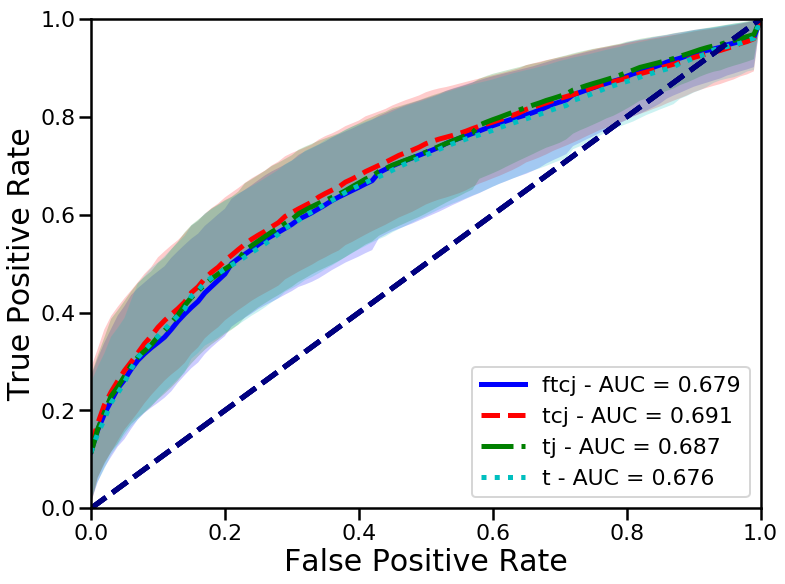

In [143]:
BackwardSelection('watch','Tremor','Multiclass',True,1.98)

[0.62855865 0.6431983  0.6390393  0.62356186] [0.57166839 0.57981153 0.58232501 0.55840768]
t 0.6431983043913355


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00685905  0.01903871  0.00700986] [-0.01584427 -0.00106215 -0.00180351]
tc 0.6622370164527647
[-0.00674853 -0.00688192] [-0.01646568 -0.01782253]
ftc 0.6554884820107406
[-0.00087388] [-0.01331675]
ftcj 0.6546145992940436


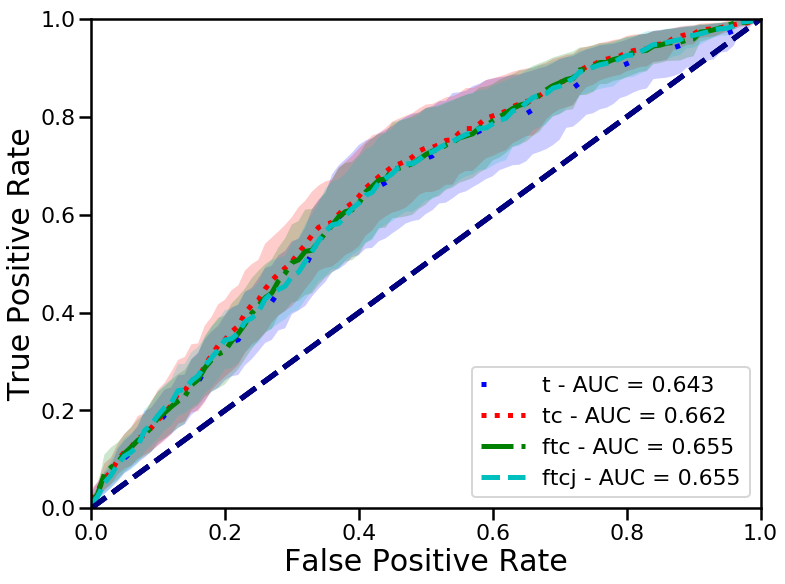

In [144]:
ForwardSelection('watch','Bradykinesia','Binary',True,1.98)

[0.60813858 0.5921203  0.59875361 0.6004262 ] [0.56505128 0.53735679 0.55129796 0.55831961]
f 0.6081385769415546


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.0102754  -0.00315392  0.00303849] [-0.0711226  -0.04030533 -0.00641631]
fj 0.6111770645701241
[-0.01139342 -0.00259101] [-0.07259809 -0.03054006]
fcj 0.6085860552074979
[-0.00789886] [-0.03996603]
ftcj 0.6006871982227807


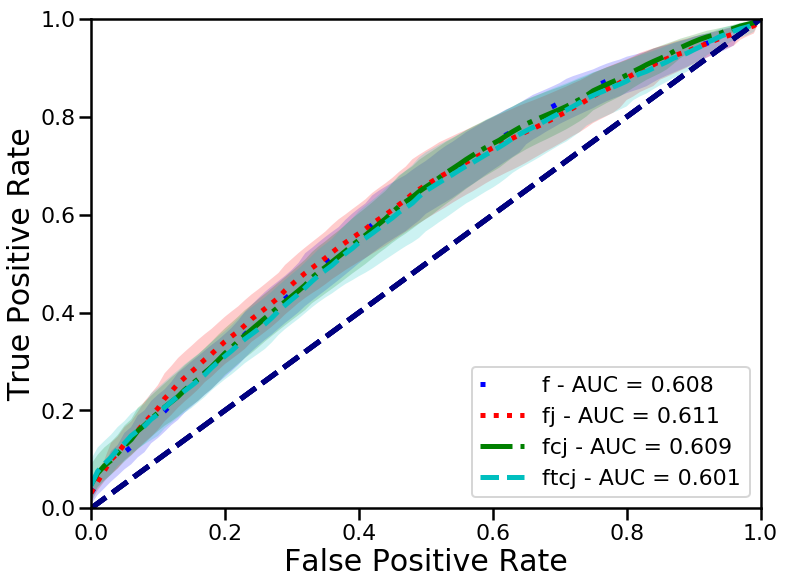

In [145]:
ForwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[ 0.00087388 -0.00657245 -0.00546432  0.0007405 ] [0.01331675 0.01676146 0.02757505 0.01482779]
ftc 0.6554884820107406
['ft', 'fc', 'tc']
[-0.01914923 -0.00672312  0.00674853] [-0.00478062  0.03306755  0.01646568]
tc 0.6622370164527647
['t', 'c']
[-0.01903871 -0.02319772] [0.00106215 0.00226833]
t 0.6622370164527647
[]


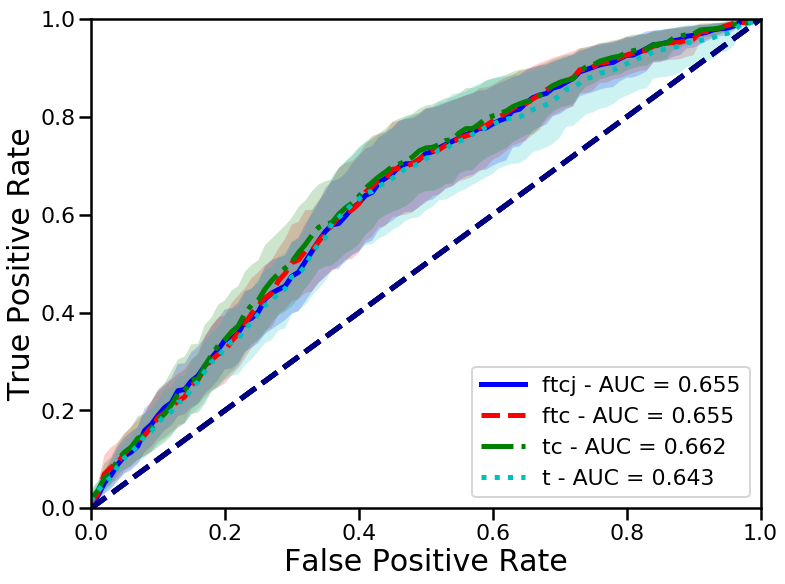

In [146]:
BackwardSelection('watch','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[ 0.0009895  -0.00090355  0.00789886  0.00441389] [0.01090168 0.01207585 0.03996603 0.01197411]
fcj 0.6085860552074979
['fc', 'fj', 'cj']
[-0.0036014   0.00259101 -0.00152308] [0.00912163 0.03054006 0.01170285]
fj 0.6111770645701241
['f', 'j']
[-0.00303849 -0.01075086] [0.00641631 0.0056002 ]
f 0.6111770645701241
[]


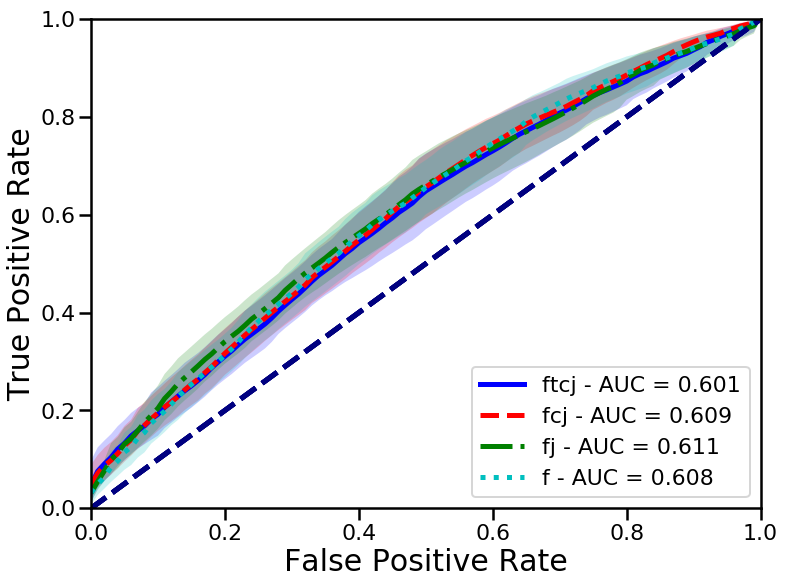

In [147]:
BackwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

[0.66741673 0.72187405 0.6815898  0.69056513] [0.61009228 0.6192455  0.59482178 0.62422738]
t 0.7218740462164916


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.00517772 0.00381391 0.0202019 ] [-0.00652948 -0.00607831  0.00136356]
tj 0.7420759479893202
[ 9.14478294e-05 -9.51320593e-03] [-0.01205278 -0.02474794]
ftj 0.7421673958187172
[7.37544831e-05] [-0.01089843]
ftcj 0.742241150301809


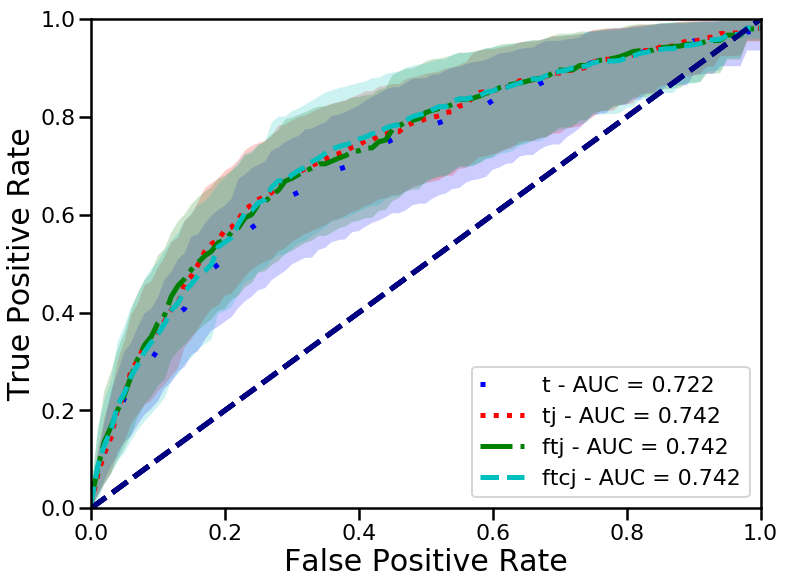

In [148]:
ForwardSelection('sensor','Tremor','Binary',True,1.98)

[0.65532365 0.697049   0.66403041 0.67252631] [0.59894465 0.59993201 0.58065259 0.6089214 ]
t 0.6970489968598014


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00037878 -0.00849408  0.01457282] [-0.01082394 -0.03138037 -0.008286  ]
tj 0.7116218149670459
[-0.00046379 -0.00299877] [-0.00838281 -0.01692963]
ftj 0.7111580269612324
[-0.00860234] [-0.02630521]
ftcj 0.70255569147337


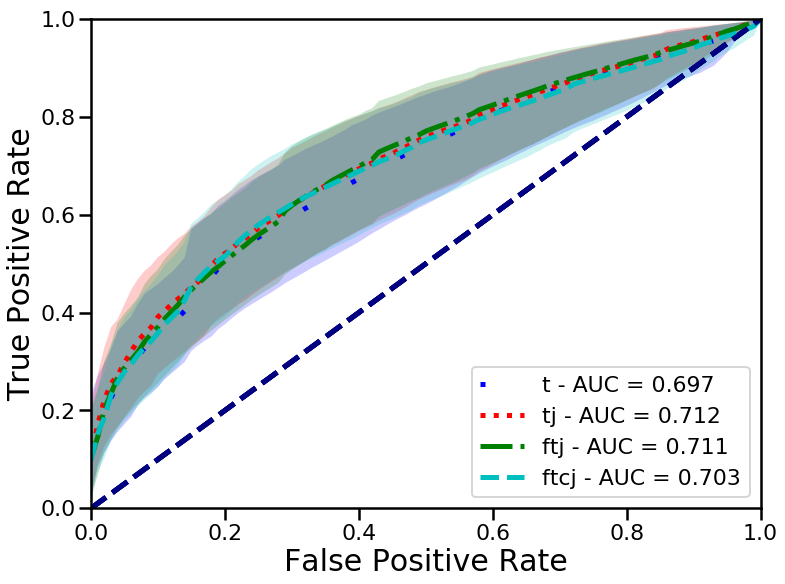

In [149]:
ForwardSelection('sensor','Tremor','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[-1.34103802e-02 -7.37544831e-05 -1.84762937e-02 -9.67840824e-03] [0.0017897  0.01089843 0.04181808 0.00630801]
ftj 0.742241150301809
['ft', 'fj', 'tj']
[-0.01518938  0.00037758 -0.0001652 ] [0.00793118 0.04433487 0.00692391]
fj 0.7426187335347675
['f', 'j']
[-0.075202  -0.0520536] [-0.04672932 -0.03220718]


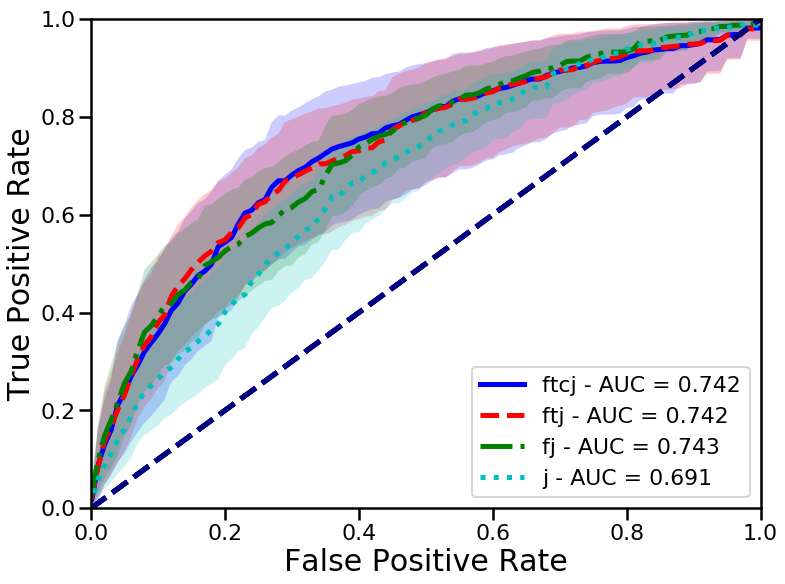

In [150]:
BackwardSelection('sensor','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[-0.0090241   0.00860234 -0.00190149  0.00606735] [0.01883189 0.02630521 0.0355809  0.01531743]
ftj 0.7111580269612324
['ft', 'fj', 'tj']
[-0.01373025  0.0032966   0.00046379] [0.00798494 0.03983327 0.00838281]
fj 0.7144546312295147
['f', 'j']
[-0.05913098 -0.04192832] [-0.03948435 -0.03062868]


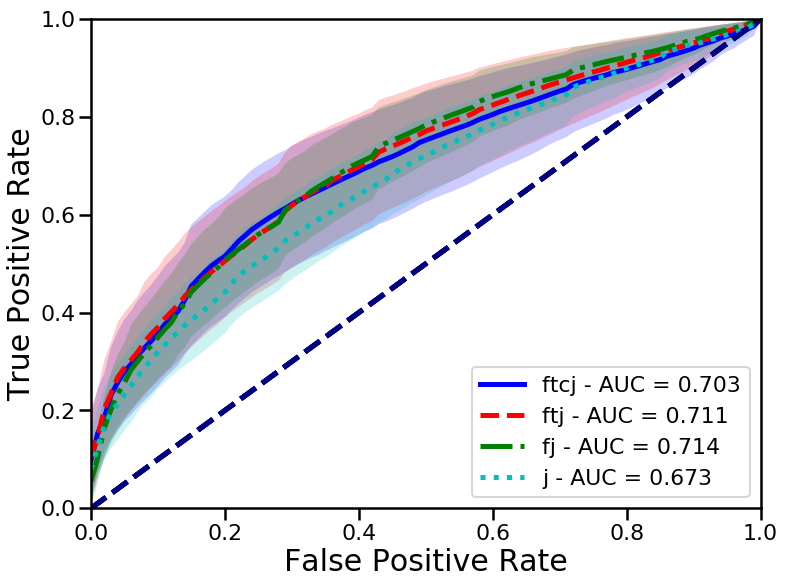

In [151]:
BackwardSelection('sensor','Tremor','Multiclass',True,1.98)

[0.65384423 0.66102288 0.61207536 0.62850232] [0.60456316 0.58665261 0.53708158 0.56732917]
t 0.6610228825596091


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00696411 -0.01316074  0.01002383] [-0.00181911 -0.0243845  -0.00257794]
tj 0.6710467133661768
[ 0.00172967 -0.01229317] [-0.00857711 -0.026411  ]
ftj 0.6727763815479335
[-0.00842545] [-0.02183486]
ftcj 0.6643509337642274


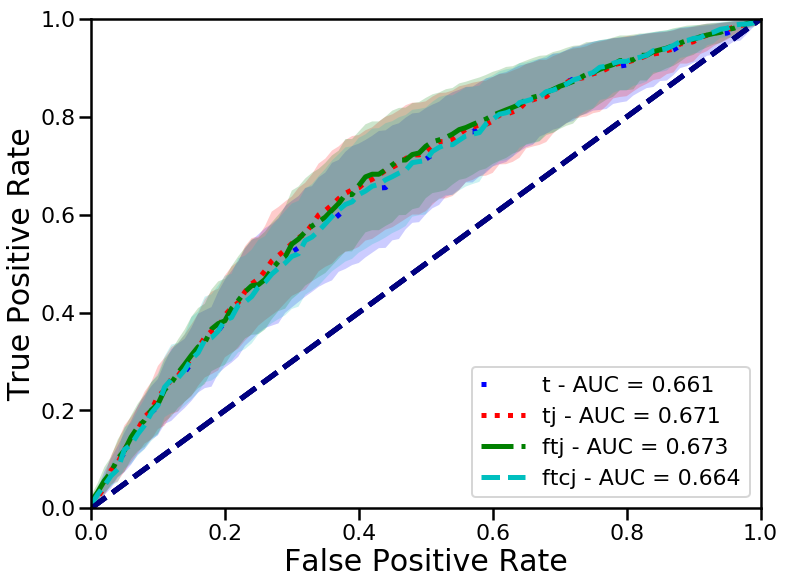

In [152]:
ForwardSelection('sensor','Bradykinesia','Binary',True,1.98)

[0.62552663 0.62674924 0.60211371 0.61085026] [0.57085189 0.56757974 0.54117599 0.55593747]
t 0.6267492435314641


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.01262224 0.00290586 0.01273078] [-0.00163363 -0.00489147  0.00373937]
tj 0.6394800228993802
[-0.00121866 -0.00952166] [-0.00820136 -0.01873233]
ftj 0.6382613632158814
[-0.0035832] [-0.01077609]
ftcj 0.6346781603328518


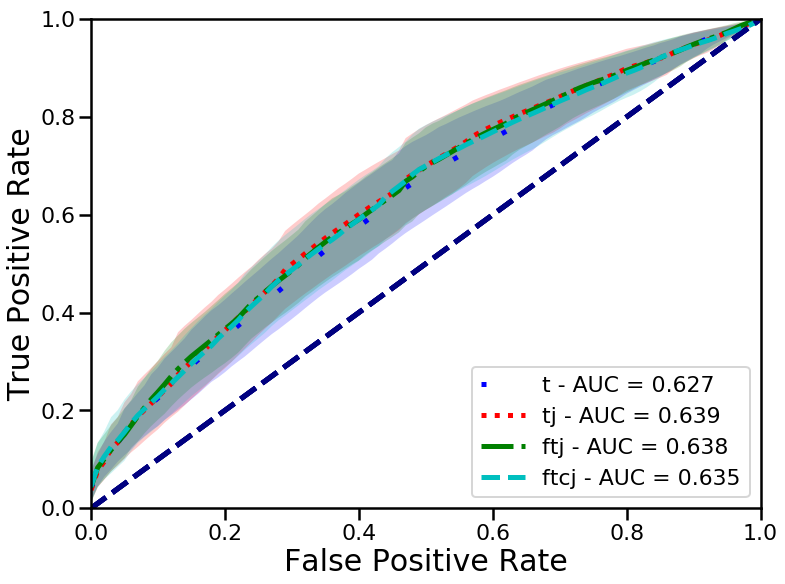

In [153]:
ForwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[-0.00304899  0.00842545 -0.01961232 -0.00559739] [ 0.0084295   0.02183486 -0.00107962  0.00619491]
ftj 0.6727763815479335
['ft', 'fj', 'tj']
[-0.00478939 -0.00636566 -0.00172967] [0.00603565 0.03175013 0.00857711]
tj 0.6727763815479335
['t', 'j']
[-0.0117535  -0.04427407] [ 0.0016933 -0.0018851]
t 0.6727763815479335
[]


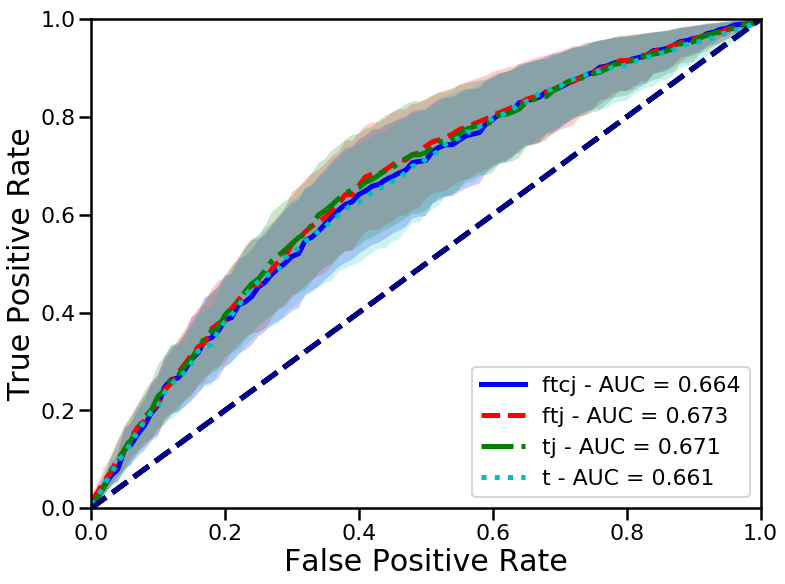

In [154]:
BackwardSelection('sensor','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftc', 'ftj', 'fcj', 'tcj']
[-0.00238189  0.0035832  -0.01134336 -0.0047198 ] [0.00817061 0.01077609 0.00619308 0.00415988]
ftj 0.6382613632158814
['ft', 'fj', 'tj']
[ 0.00111012 -0.00565164  0.00121866] [0.01032501 0.02163803 0.00820136]
tj 0.6394800228993802
['t', 'j']
[-0.01273078 -0.02862976] [-0.00373937  0.00570454]


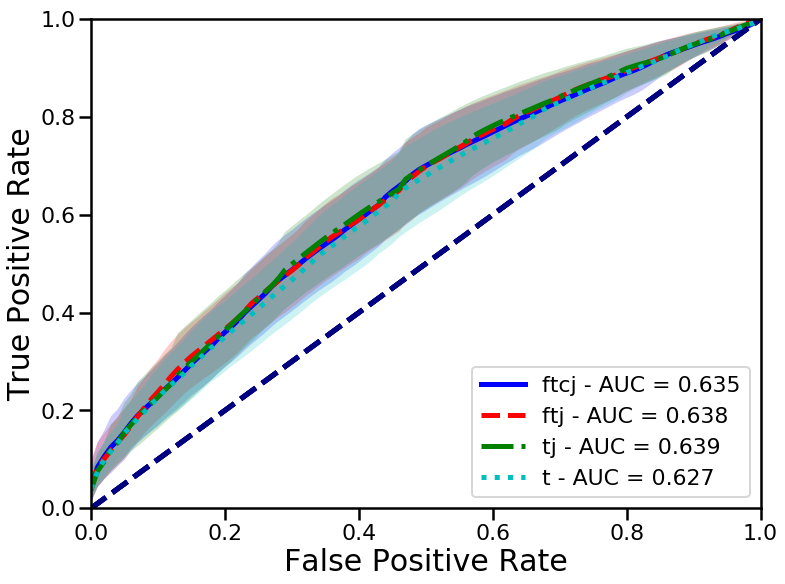

In [155]:
BackwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

## Full Frequency Results

[0.63413155 0.74052714 0.70293304 0.64889291 0.72431716] [0.5561089  0.62299899 0.61145263 0.5882491  0.6317809 ]
t 0.7405271366119716


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.00062814 0.00626705 0.00839077 0.00043132] [-0.00540976 -0.00046852  0.00188304 -0.00622854]
tj 0.7489179039394382
[ 0.0012112   0.00590567 -0.0060462 ] [-0.00842867 -0.00219639 -0.01522618]


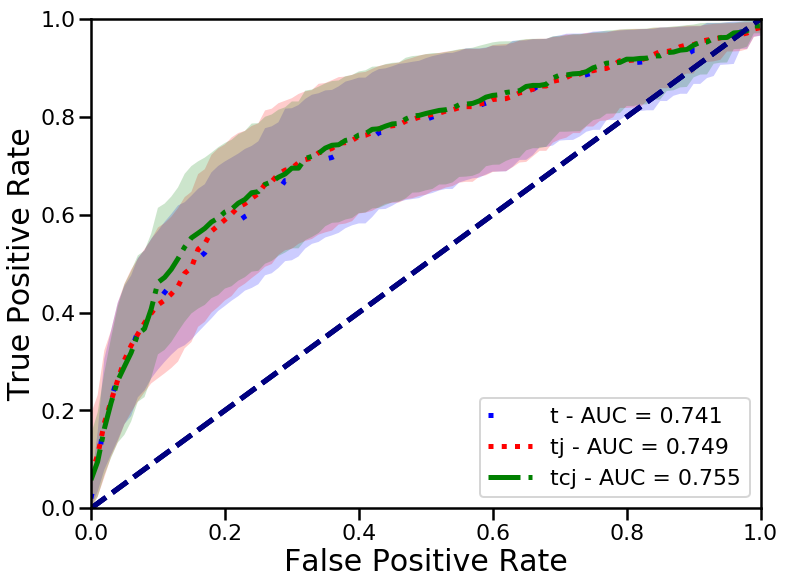

In [126]:
ForwardSelection('watch','Tremor','Binary',True,1.98)

[0.6347964  0.7206203  0.67999214 0.64814694 0.7059192 ] [0.56185342 0.61974718 0.59617297 0.58748283 0.62103274]
t 0.7206203024317174


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.01026765 -0.0032646   0.00657761  0.0085385 ] [-0.00454277 -0.0128069  -0.00466054 -0.00582617]


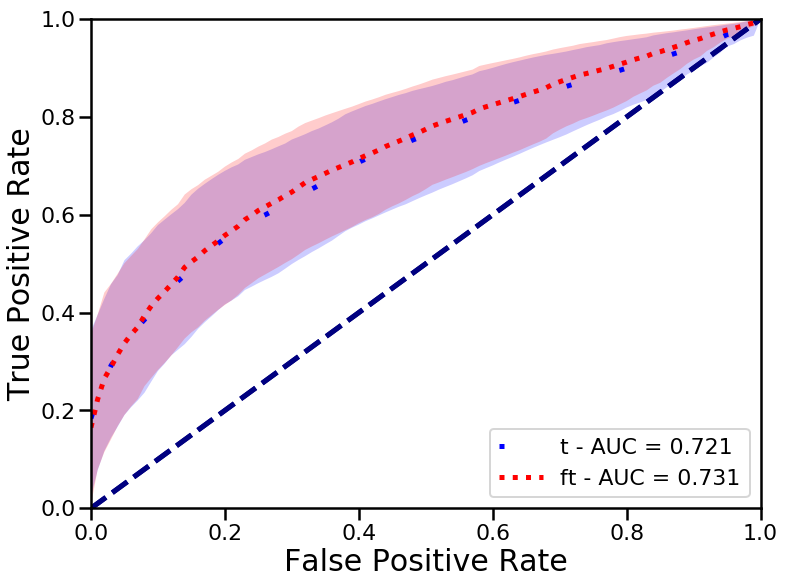

In [127]:
ForwardSelection('watch','Tremor','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[ 0.00352968 -0.00491132 -0.0008777   0.00726307  0.00171464] [0.01502936 0.00845383 0.01657897 0.02977566 0.01375465]
fcjm 0.7581560452612238
['fcj', 'fcm', 'fjm', 'cjm']
[-0.01657592 -0.01212123 -0.00576455 -0.0042578 ] [-0.00419329  0.00325544  0.01925963  0.00946147]
cjm 0.7538982434168666
['cj', 'cm', 'jm']
[-0.01767174 -0.01476016 -0.01890513] [0.00891056 0.00038827 0.0033131 ]
cm 0.7391380821889426
['c', 'm']
[-0.03620504 -0.01482092] [-0.0185425   0.01494045]
m 0.7243171609231217
[]


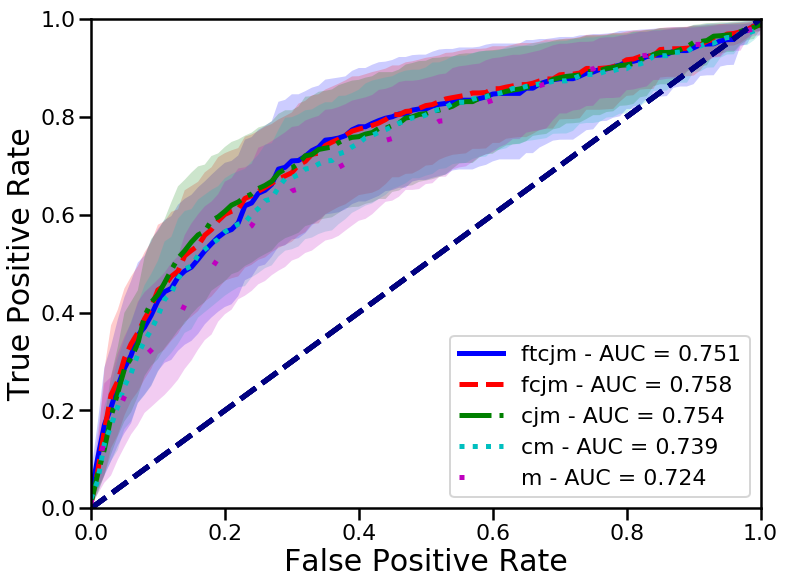

In [128]:
BackwardSelection('watch','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.00417971 -0.00129927 -0.00134066  0.00269025 -0.00096364] [0.00387622 0.00568948 0.00455996 0.02430681 0.00533666]
fcjm 0.7342896558970955
['fcj', 'fcm', 'fjm', 'cjm']
[-0.0097294  -0.02420394 -0.00665151 -0.01083965] [ 0.0006025  -0.00477616  0.01360045 -0.00124185]
fjm 0.7276381432409388
['fj', 'fm', 'jm']
[-0.03071385 -0.01017926 -0.00628005] [-0.01876695  0.00096063  0.00214503]
jm 0.7213580898909782
['j', 'm']
[-0.07321115 -0.01543889] [-0.03472176 -0.00570002]


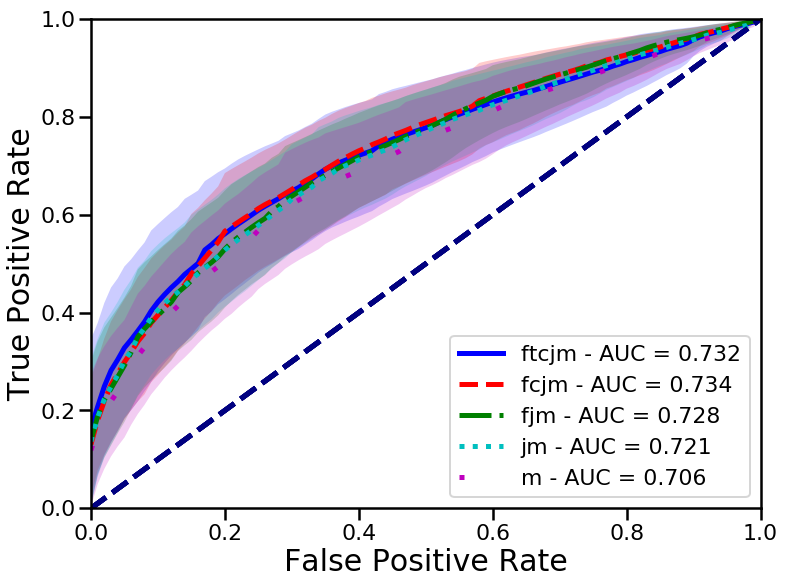

In [129]:
BackwardSelection('watch','Tremor','Multiclass',True,1.98)

[0.59084047 0.60495845 0.61465267 0.57637163 0.59504909] [0.53903998 0.54744566 0.5522752  0.51923741 0.53291753]
c 0.6146526709416694


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00688353  0.00202408 -0.00488358 -0.00147213] [-0.02869863 -0.02855829 -0.02502203 -0.0239676 ]


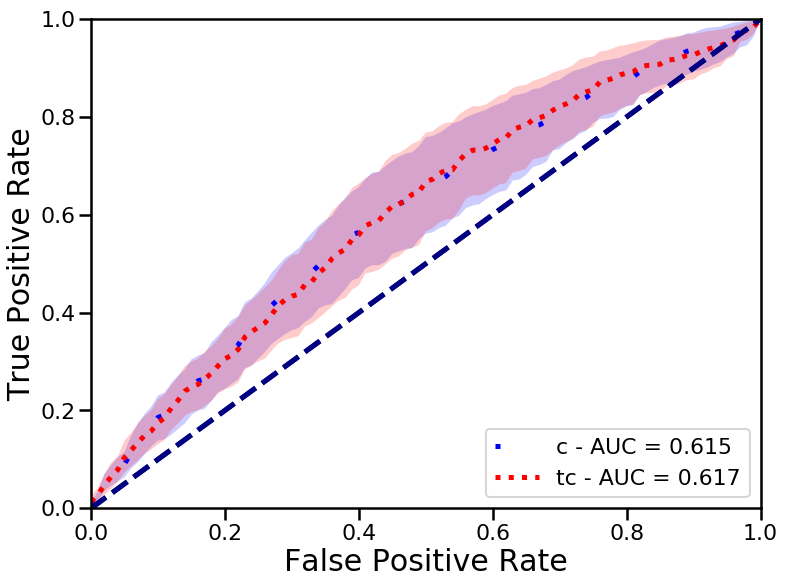

In [130]:
ForwardSelection('watch','Bradykinesia','Binary',True,1.98)

[0.57954633 0.5844103  0.59050081 0.56414244 0.57515929] [0.54069583 0.53364575 0.54211008 0.5217076  0.52450883]
c 0.5905008133277089


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00132369 -0.01141793 -0.01186572 -0.00622109] [-0.01816968 -0.05142558 -0.02721478 -0.03684049]


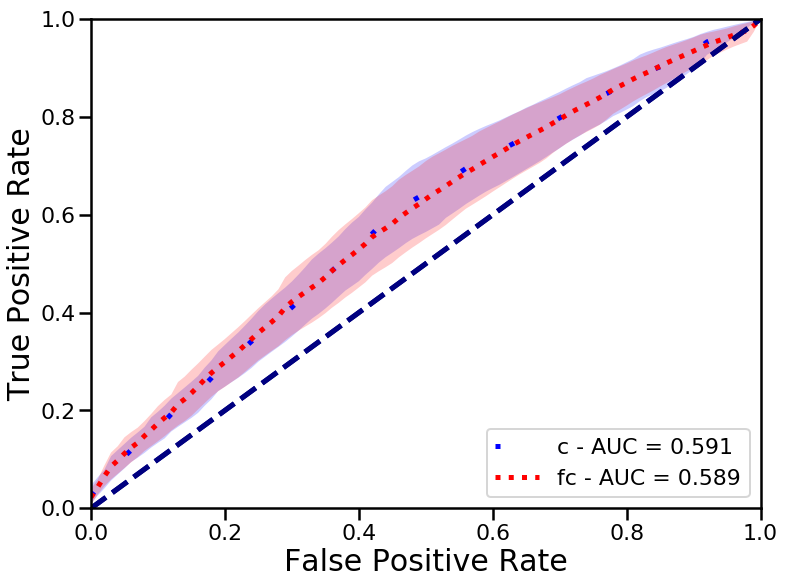

In [131]:
ForwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[ 0.00427031 -0.01404325 -0.01450113 -0.01079502 -0.00541588] [ 0.01313263 -0.00204844  0.00418041  0.01164706  0.00483634]
ftcj 0.6262974145112475
['ftc', 'ftj', 'fcj', 'tcj']
[-0.01886573 -0.00829915 -0.01519274 -0.01193639] [-0.0070124   0.00131539  0.01058545 -0.00332865]
ftj 0.6179982627999994
['ft', 'fj', 'tj']
[-0.00586184 -0.01859467 -0.00449177] [0.00729999 0.0173976  0.00757715]
tj 0.6135064930610107
['t', 'j']
[-0.00854805 -0.03713486] [0.00922798 0.00029509]
t 0.6049584475153459
[]


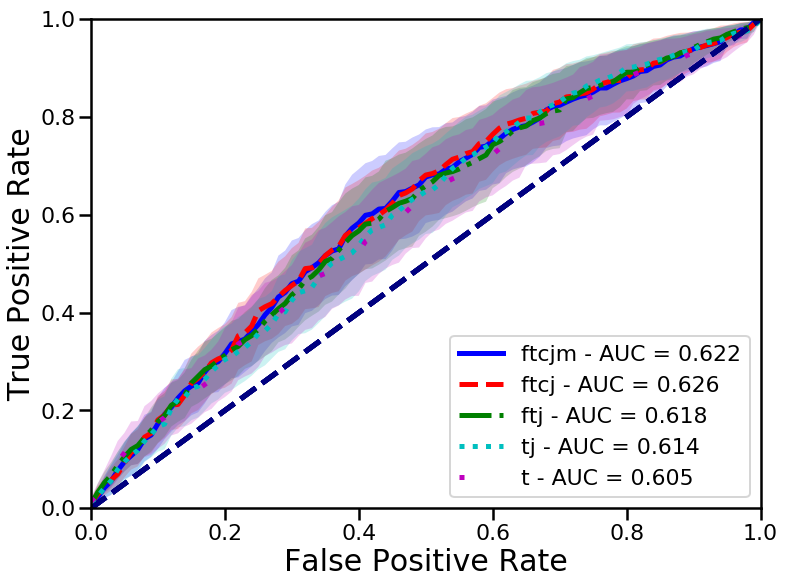

In [132]:
BackwardSelection('watch','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[0.00671474 0.0015732  0.00042637 0.01255815 0.00811523] [0.01705156 0.0110557  0.01665176 0.04029799 0.02095688]
fcjm 0.595730251815616
['fcj', 'fcm', 'fjm', 'cjm']
[-0.01199796 -0.0133667  -0.00113586 -0.00253086] [-1.53697098e-03  1.66226002e-05  8.81614278e-03  1.02964596e-02]
fjm 0.5945943884833096
['fj', 'fm', 'jm']
[-0.00787459 -0.00496623  0.00440814] [0.00431976 0.00636793 0.01434027]
jm 0.5990025316428287
['j', 'm']
[-0.03486009 -0.02384324] [-0.0034896 -0.0109785]


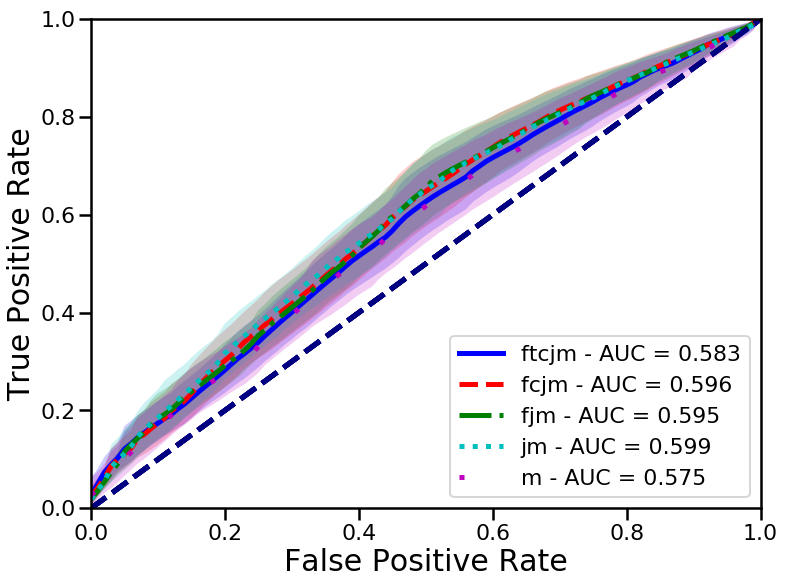

In [133]:
BackwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

[0.67253949 0.76133949 0.67568157 0.7036886  0.76014521] [0.61983834 0.66939147 0.58467967 0.6241786  0.68658518]
t 0.7613394901022844


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[-0.00299547 -0.00531533 -0.00121891  0.00426849] [-0.01183354 -0.01557043 -0.01642706 -0.0036183 ]


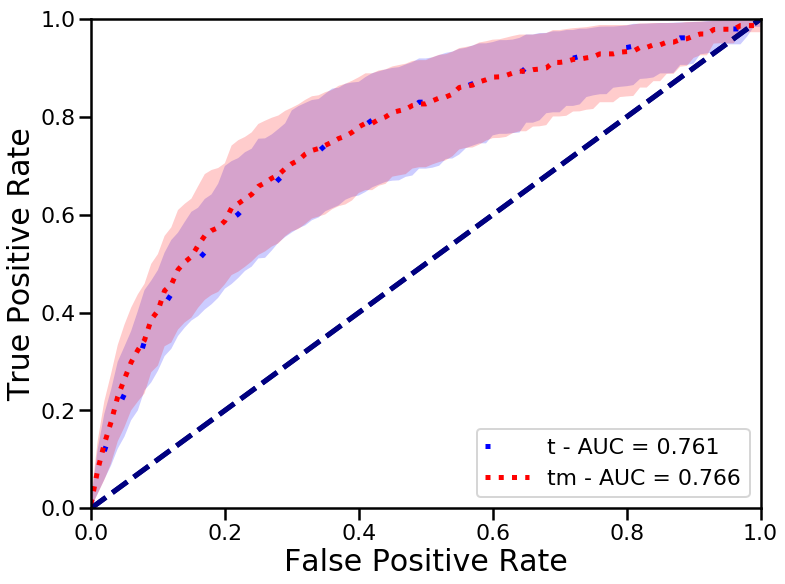

In [134]:
ForwardSelection('sensor','Tremor','Binary',True,1.98)

[0.64335573 0.72293033 0.65908872 0.69052533 0.73332437] [0.59070331 0.63693969 0.57741114 0.61310487 0.66016183]
m 0.7333243680553516


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[0.00089595 0.00390222 0.00293796 0.00485486] [-0.00998667 -0.01778193 -0.01666427 -0.01464886]


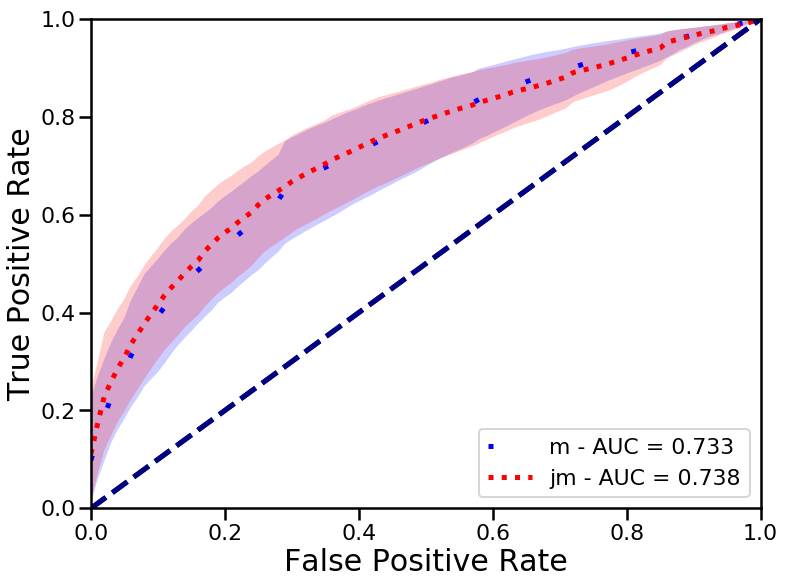

In [135]:
ForwardSelection('sensor','Tremor','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[ 0.0024475   0.00719755  0.00851759 -0.00348472  0.00488457] [0.00881345 0.02000988 0.01373656 0.01325546 0.0093896 ]
ftjm 0.7669448999445733
['ftj', 'ftm', 'fjm', 'tjm']
[-0.00677456  0.00058691 -0.00273991  0.00026941] [-0.00197375  0.00792976  0.02577336  0.00899297]
ftm 0.7675318100151322
['ft', 'fm', 'tm']
[-0.00918779  0.00188593 -0.00192383] [0.00107834 0.02892823 0.00774886]
fm 0.7694177443923736
['f', 'm']
[-0.09687826 -0.00927253] [-0.06299048  0.00113149]
m 0.7601452104867127
[]


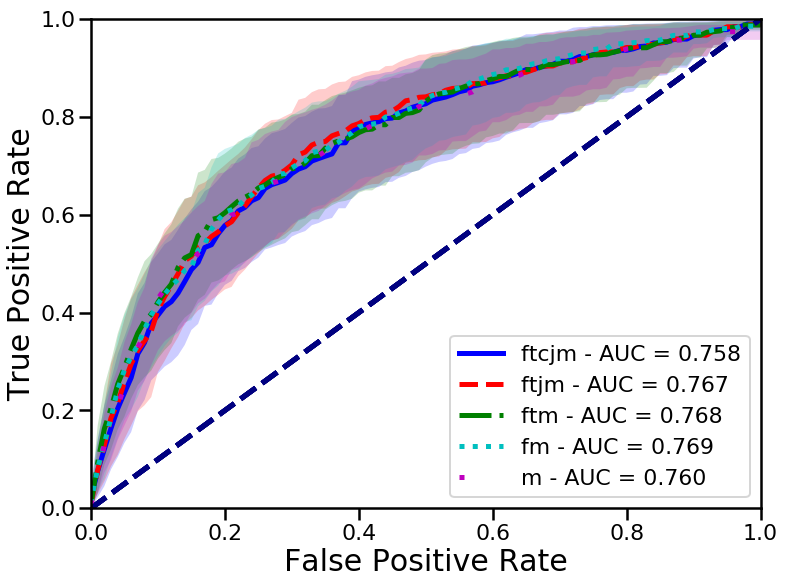

In [136]:
BackwardSelection('sensor','Tremor','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-6.78503568e-03  1.45345751e-03  7.05900912e-05  5.73244370e-03
  1.29073106e-03] [-0.00165449  0.01226609  0.00477592  0.02463347  0.01383763]
fcjm 0.7405349699398923
['fcj', 'fcm', 'fjm', 'cjm']
[-0.04917557  0.00107621  0.0048627  -0.00197651] [0.01616694 0.01719711 0.01615724 0.01054459]
fjm 0.745397672128
['fj', 'fm', 'jm']
[-0.03688661 -0.01117736 -0.00721844] [-0.01413203  0.00221718 -0.00085951]


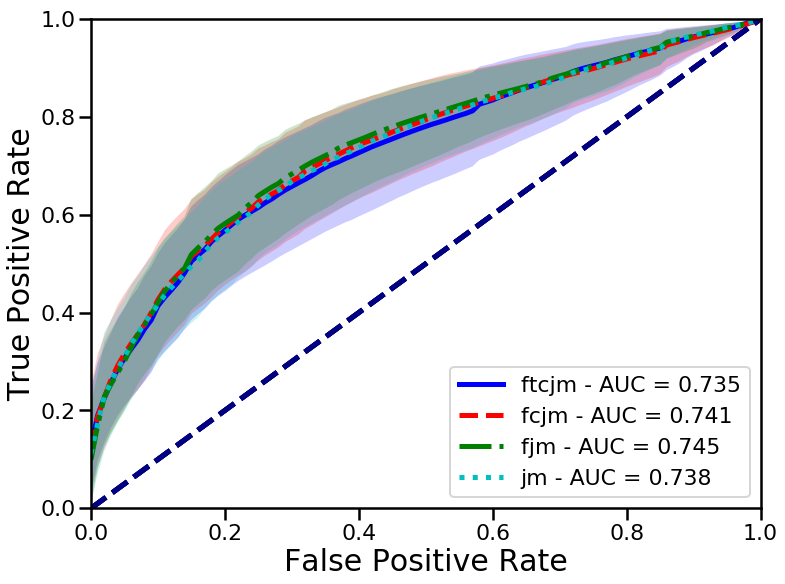

In [137]:
BackwardSelection('sensor','Tremor','Multiclass',True,1.98)

[0.64898344 0.67680078 0.62607211 0.62942212 0.66364946] [0.60434054 0.61307332 0.55217281 0.57227221 0.61055325]
t 0.6768007751327507


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00763979 -0.00797629  0.00429873  0.01181813] [-0.0009043  -0.02564053 -0.00375295 -0.00043224]


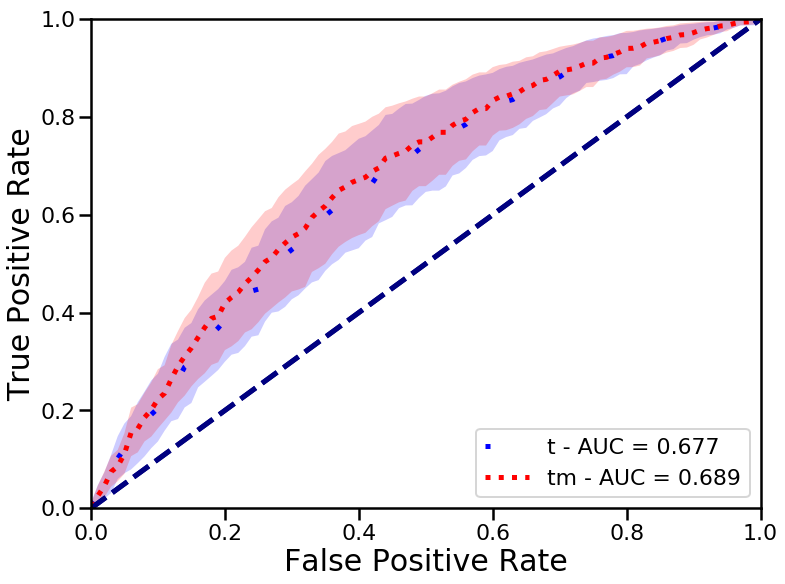

In [138]:
ForwardSelection('sensor','Bradykinesia','Binary',True,1.98)

[0.62190772 0.65189014 0.60267287 0.61639071 0.63353874] [0.57374297 0.59591476 0.54144768 0.56403912 0.57593283]
t 0.6518901436976099


C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


[ 0.00783481 -0.00361147  0.00073657  0.00279089] [-0.00155568 -0.01340804 -0.01113486 -0.00241187]


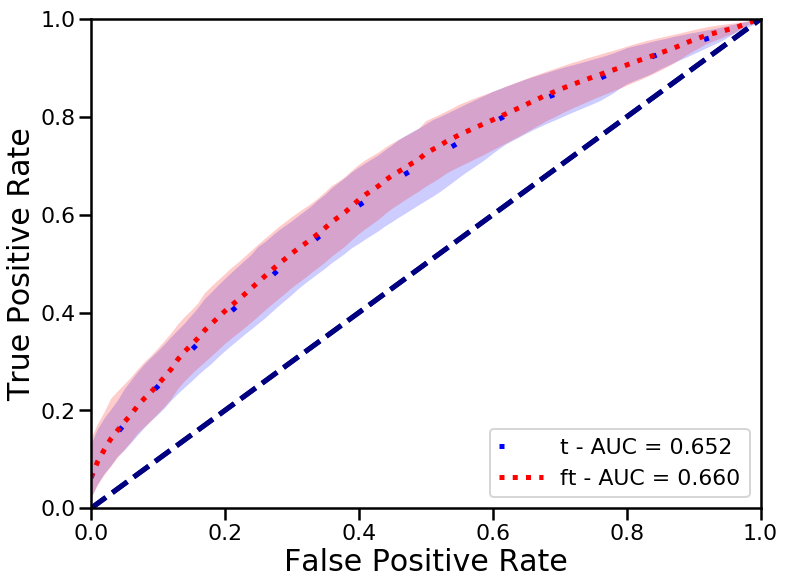

In [139]:
ForwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.0052403  -0.00263404  0.0057088  -0.03067915 -0.00413513] [ 0.003207    0.00816523  0.02061903 -0.01175286  0.0067253 ]
ftjm 0.6883338848025324
['ftj', 'ftm', 'fjm', 'tjm']
[-0.01225871 -0.00568744 -0.01408834 -0.00549541] [-0.00088447  0.00697675  0.01680169  0.00099254]
tjm 0.6828384783905582
['tj', 'tm', 'jm']
[-0.00173897  0.00578043 -0.01457192] [0.0072251  0.0153133  0.01570257]
tm 0.6886189070460726
['t', 'm']
[-0.01181813 -0.02496945] [0.00043224 0.00617661]
t 0.6768007751327507
[]


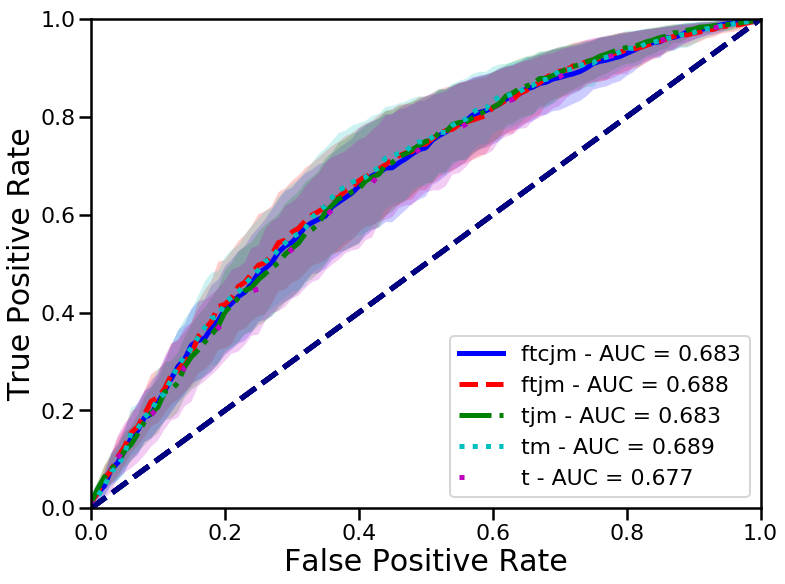

In [140]:
BackwardSelection('sensor','Bradykinesia','Binary',True,1.98)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


['ftcj', 'ftcm', 'ftjm', 'fcjm', 'tcjm']
[-0.00604175 -0.00869863 -0.004592   -0.01888522 -0.01111681] [ 0.0056578  -0.00011531  0.00651621 -0.00418792 -0.00309026]
ftjm 0.655196858220057
['ftj', 'ftm', 'fjm', 'tjm']
[ 0.0060291   0.00467503 -0.00958272  0.00144555] [0.01802    0.01696775 0.0130765  0.01567383]
ftj 0.6612259610621474
['ft', 'fj', 'tj']
[-0.00150101 -0.03008566 -0.00859925] [0.00819521 0.00253893 0.0027926 ]
ft 0.659724951197068
['f', 't']
[-0.03781723 -0.00783481] [-0.00686483  0.00155568]
t 0.6518901436976099
[]


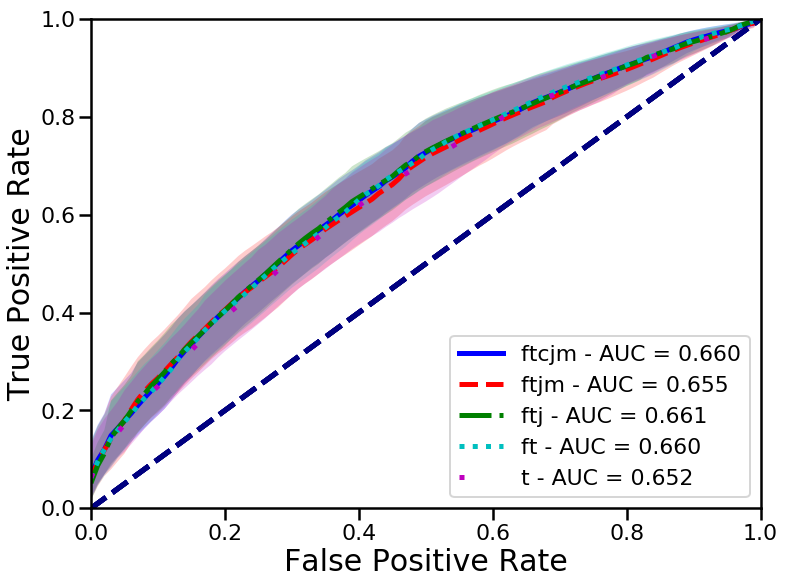

In [141]:
BackwardSelection('sensor','Bradykinesia','Multiclass',True,1.98)

In [53]:
from sklearn.feature_selection import RFE

In [ ]:
RFE

In [87]:
m = np.mean([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])
s = np.std([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])

In [142]:
[-9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18]*-1

[]

In [115]:
mode = 'watch'; symptom = 'Tremor'; classifier = 'Binary'; CIBound = True; CIZ = 1.98

groups = results[mode][symptom][classifier]['res_all']['Combination'].values
data = results[mode][symptom][classifier]['res_groups']

done = False
opt_feat = ''
current_auc = 0

if classifier == 'Binary':

    AUC = pd.DataFrame()
    for i in range(len(data)):
        AUC[groups[i]] = data[i]['Random Forest']['auroc']


    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if (len(g)==n) & all([(o in g) for o in opt_feat])]
        if len(n_groups)<1:
            break
        auc_groups = [AUC[g].mean()-np.nanmean(current_auc) for g in n_groups]
        auc_sem = [stats.sem(aucdf[g].values-current_auc, nan_policy='omit') for g in n_groups]
        print(auc_groups,[g-CIZ*s for g,s in zip(auc_groups, auc_sem)])
        max_ind = np.argmax(auc_groups)
        if CIBound:
            if (auc_groups[max_ind]-(CIZ*auc_sem[max_ind]))>0:
                opt_feat = n_groups[max_ind]
                current_auc = aucdf[opt_feat].values
                print(opt_feat,current_auc)
            else:
                done = True
        else:
            if auc_groups[max_ind]>np.mean(current_auc):
                opt_feat = n_groups[max_ind]
                current_auc = AUC[opt_feat]
                print(opt_feat,current_auc)
            else:
                done = True

[0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051] [0.5584174275461221, 0.6241088839085511, 0.601897422547087, 0.5863983287020665, 0.6271129660188752]
t [0.70561294 0.81037706 0.86186017 0.73196066 0.35612374 0.72138692
 0.7516752  0.99869281 0.94657467 0.82804711        nan 0.24381238
 0.86427346 0.82945014]
[0.00016780670521299168, 0.002212182690734754, 0.006437808633695585, -0.0009021098001887884] [-0.008308870837258852, -0.0026934758857538174, -0.0051464284074526825, -0.009070958307743392]


In [106]:
auc_sem

[nan, nan, nan, nan, nan]

In [10]:
def barplotFeatures(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Combination'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Combination']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Feature Sets')
    plt.title('%s Model Performance v. %s Features: %s'%(classifier,mode,symptom))
    print('f: frequency')
    print('t: time')
    print('c: correlation')
    print('j: jerk')
    print('m: mag')
    
    plt.savefig('Results/Features_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [11]:
def stats_tests(mode,symptom,classifier):
    #dataframe for reorganizing data
    df = pd.DataFrame()
    comblist = list(results[mode][symptom][classifier]['res_all']['Combination'])
    if classifier == 'Binary':
        for i in range(len(comblist)):
            comb = comblist[i]
            df[comb] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['f'].isnull()].reset_index(drop=True)
    else:
        for comb in comblist:
            df[comb] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Combination']==comb]['RMS']
        df = df.reset_index(drop=True)

    #rmANOVA
    print()
    print('Repeated Measures ANOVA')
    print('All feature subsets')
    print('pvalue: ' + str(rmANOVA(df,df.columns.values)))
    print('f,t,j,c,m,ftcjm')
    print('pvalue: ' + str(rmANOVA(df,['f','t','j','c','m','ftcjm'])))
    print()
    
    #t tests
    for comb in ['f','t','c','j','m']:
        p = stats.ttest_rel(df['ftcjm'],df[comb])
        print('ftcjm, %s'%comb)
        print(p)

In [12]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.2407294855751674e-15
f,t,j,c,m,ftcjm
pvalue: 1.838185647828629e-05

ftcjm, f
Ttest_relResult(statistic=4.013325133360871, pvalue=0.0017199744127328195)
ftcjm, t
Ttest_relResult(statistic=1.145317907406181, pvalue=0.27440615312625705)
ftcjm, c
Ttest_relResult(statistic=2.676990119814746, pvalue=0.02014873731864096)
ftcjm, j
Ttest_relResult(statistic=2.8353209569720144, pvalue=0.015026630531448171)
ftcjm, m
Ttest_relResult(statistic=1.5633100588561193, pvalue=0.14395488627636344)


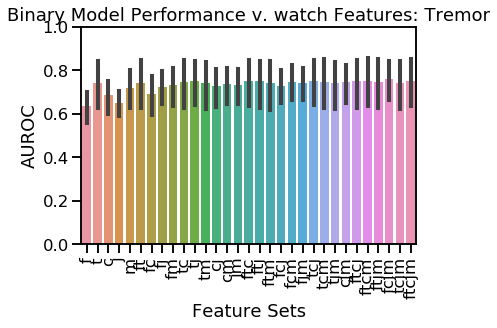

In [14]:
barplotFeatures('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.80291136016951e-69
f,t,j,c,m,ftcjm
pvalue: 8.555604610338152e-11

ftcjm, f
Ttest_relResult(statistic=-6.497546731549849, pvalue=2.011257077481974e-05)
ftcjm, t
Ttest_relResult(statistic=-9.137665359108434, pvalue=5.069081163280519e-07)
ftcjm, c
Ttest_relResult(statistic=1.4452832072014001, pvalue=0.1720505627928243)
ftcjm, j
Ttest_relResult(statistic=-4.235692478549739, pvalue=0.000972729585186152)
ftcjm, m
Ttest_relResult(statistic=-11.322280814619132, pvalue=4.183404420131731e-08)


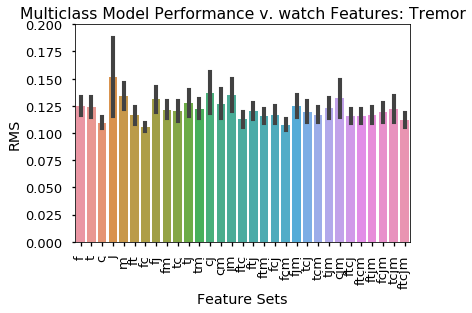

In [98]:
barplotFeatures('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 3.2011690391667044e-37
f,t,j,c,m,ftcjm
pvalue: 2.956897821741187e-07

ftcjm, f
Ttest_relResult(statistic=-7.4468636820002505, pvalue=4.855684711357836e-06)
ftcjm, t
Ttest_relResult(statistic=-1.123970306635543, pvalue=0.28135253683103006)
ftcjm, c
Ttest_relResult(statistic=-7.155904374450818, pvalue=7.413102626725193e-06)
ftcjm, j
Ttest_relResult(statistic=-3.5763197236104003, pvalue=0.0033816465118064196)
ftcjm, m
Ttest_relResult(statistic=-8.411565292257393, pvalue=1.2857220922194676e-06)


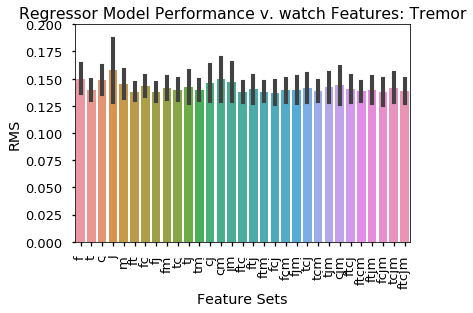

In [99]:
barplotFeatures('watch','Tremor','Regressor')
stats_tests('watch','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 0.02236252961477201
f,t,j,c,m,ftcjm
pvalue: 0.014054486068820295

ftcjm, f
Ttest_relResult(statistic=2.071765291305611, pvalue=0.05874189913100713)
ftcjm, t
Ttest_relResult(statistic=0.7806440727035838, pvalue=0.4489938411327704)
ftcjm, c
Ttest_relResult(statistic=0.837624645353771, pvalue=0.4173755872893369)
ftcjm, j
Ttest_relResult(statistic=3.4065091692527414, pvalue=0.004683385101066986)
ftcjm, m
Ttest_relResult(statistic=1.9695213695148555, pvalue=0.07058120004170562)


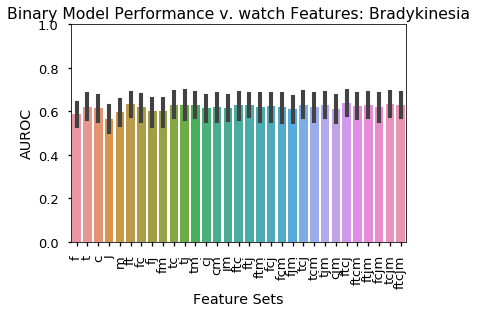

In [100]:
barplotFeatures('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.169488526057966e-57
f,t,j,c,m,ftcjm
pvalue: 3.0065664718046995e-13

ftcjm, f
Ttest_relResult(statistic=-6.404954473630804, pvalue=2.3251877057090184e-05)
ftcjm, t
Ttest_relResult(statistic=-7.666402147095121, pvalue=3.5535325752105695e-06)
ftcjm, c
Ttest_relResult(statistic=-1.9177089935629226, pvalue=0.07738298318668856)
ftcjm, j
Ttest_relResult(statistic=-3.551367051969363, pvalue=0.0035471135837327927)
ftcjm, m
Ttest_relResult(statistic=-7.083949255728951, pvalue=8.244568064282004e-06)


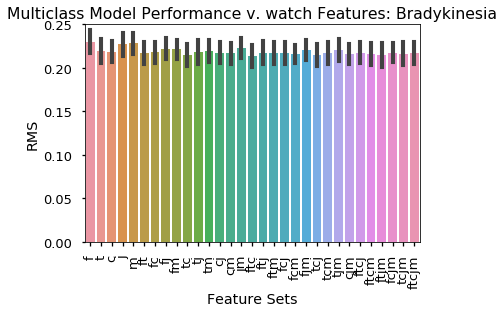

In [101]:
barplotFeatures('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 2.8273466972509897e-40
f,t,j,c,m,ftcjm
pvalue: 0.0078120004404435665

ftcjm, f
Ttest_relResult(statistic=-0.8561662213664254, pvalue=0.4074105222362535)
ftcjm, t
Ttest_relResult(statistic=-3.8041630642022466, pvalue=0.0021899497866711)
ftcjm, c
Ttest_relResult(statistic=3.667981102590287, pvalue=0.0028382080301270008)
ftcjm, j
Ttest_relResult(statistic=0.5238851211355995, pvalue=0.6091744613152681)
ftcjm, m
Ttest_relResult(statistic=-3.3576957182615135, pvalue=0.00514402684981597)


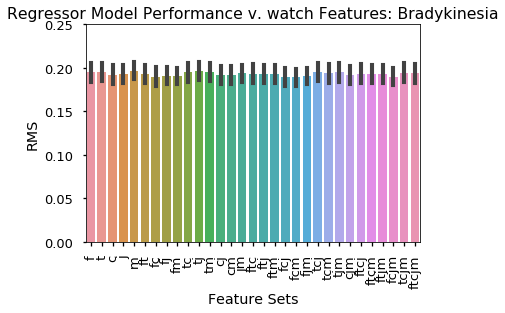

In [102]:
barplotFeatures('watch','Bradykinesia','Regressor')
stats_tests('watch','Bradykinesia','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 4.913549054689126e-29
f,t,j,c,m,ftcjm
pvalue: 4.2425835276363614e-09

ftcjm, f
Ttest_relResult(statistic=4.357283373280962, pvalue=0.00114144646344756)
ftcjm, t
Ttest_relResult(statistic=1.8050029230751985, pvalue=0.098489939742494)
ftcjm, c
Ttest_relResult(statistic=5.631242779591054, pvalue=0.0001530219102856899)
ftcjm, j
Ttest_relResult(statistic=3.6137452250176443, pvalue=0.0040707760701365085)
ftcjm, m
Ttest_relResult(statistic=0.8157908024144905, pvalue=0.4319303500086208)


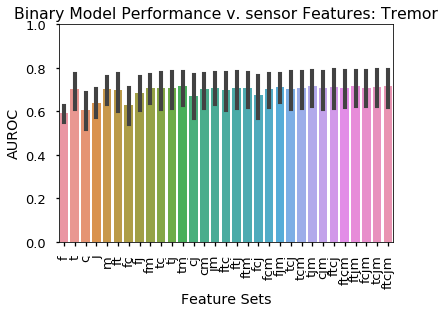

In [103]:
barplotFeatures('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.906097194895458e-69
f,t,j,c,m,ftcjm
pvalue: 6.546562983963116e-14

ftcjm, f
Ttest_relResult(statistic=-3.570893216984144, pvalue=0.003846075232328544)
ftcjm, t
Ttest_relResult(statistic=-5.893765293080565, pvalue=7.323159141508633e-05)
ftcjm, c
Ttest_relResult(statistic=-2.4358245379721595, pvalue=0.03139655735073362)
ftcjm, j
Ttest_relResult(statistic=-5.043564930979698, pvalue=0.00028758868633502725)
ftcjm, m
Ttest_relResult(statistic=-9.809724200778808, pvalue=4.4057305548799193e-07)


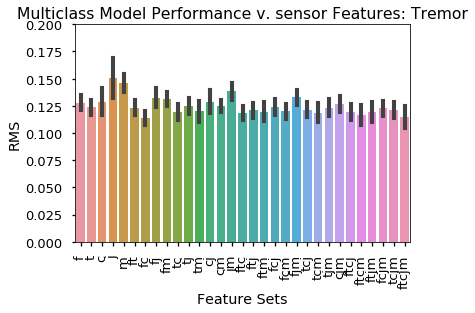

In [104]:
barplotFeatures('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.218660030331608e-46
f,t,j,c,m,ftcjm
pvalue: 2.1175555596730666e-08

ftcjm, f
Ttest_relResult(statistic=-6.807450979507581, pvalue=1.8828065541660424e-05)
ftcjm, t
Ttest_relResult(statistic=-7.7068055584924355, pvalue=5.49885521147907e-06)
ftcjm, c
Ttest_relResult(statistic=-4.056460445584815, pvalue=0.0015917768386960213)
ftcjm, j
Ttest_relResult(statistic=-4.248108015498546, pvalue=0.001131090549937487)
ftcjm, m
Ttest_relResult(statistic=-15.076633720714018, pvalue=3.666374153420389e-09)


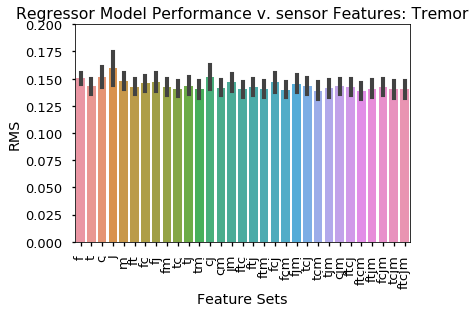

In [105]:
barplotFeatures('sensor','Tremor','Regressor')
stats_tests('sensor','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.0464594904077247e-23
f,t,j,c,m,ftcjm
pvalue: 7.1816811720361404e-06

ftcjm, f
Ttest_relResult(statistic=2.6019451072695254, pvalue=0.023142777884312345)
ftcjm, t
Ttest_relResult(statistic=-1.6025145159401066, pvalue=0.13502241540277649)
ftcjm, c
Ttest_relResult(statistic=5.153503037105223, pvalue=0.0002395936405312925)
ftcjm, j
Ttest_relResult(statistic=3.2989621823362896, pvalue=0.006352951981568172)
ftcjm, m
Ttest_relResult(statistic=2.180479433680845, pvalue=0.04985100470654528)


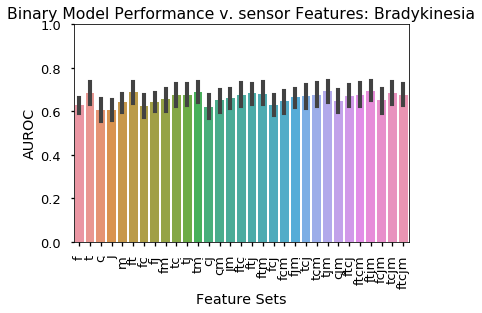

In [106]:
barplotFeatures('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.480002033406227e-35
f,t,j,c,m,ftcjm
pvalue: 6.822754677101919e-10

ftcjm, f
Ttest_relResult(statistic=-1.7117383346874868, pvalue=0.11264326340178274)
ftcjm, t
Ttest_relResult(statistic=-2.408604035271517, pvalue=0.03299670572989949)
ftcjm, c
Ttest_relResult(statistic=-3.7259979431812074, pvalue=0.0028949952958685784)
ftcjm, j
Ttest_relResult(statistic=-1.5335150670261695, pvalue=0.15108117972836227)
ftcjm, m
Ttest_relResult(statistic=-11.49797843992827, pvalue=7.773795266251136e-08)


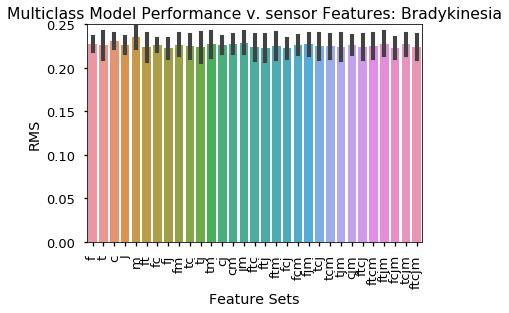

In [107]:
barplotFeatures('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.4259586406033631e-21
f,t,j,c,m,ftcjm
pvalue: 2.8026025859182626e-05

ftcjm, f
Ttest_relResult(statistic=-1.4427561509533138, pvalue=0.17467984338227868)
ftcjm, t
Ttest_relResult(statistic=-8.155921998435492, pvalue=3.0839935042733542e-06)
ftcjm, c
Ttest_relResult(statistic=-6.247577439293316, pvalue=4.2699047868308586e-05)
ftcjm, j
Ttest_relResult(statistic=-0.204055681767295, pvalue=0.8417296959472884)
ftcjm, m
Ttest_relResult(statistic=-6.889190704028311, pvalue=1.676467917156864e-05)


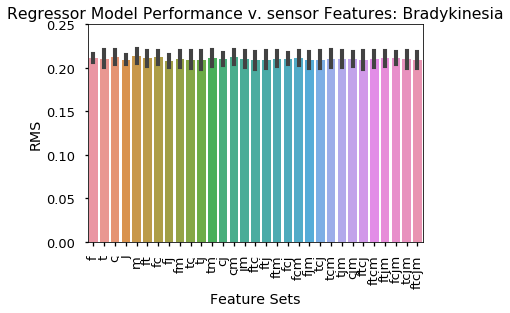

In [108]:
barplotFeatures('sensor','Bradykinesia','Regressor')
stats_tests('sensor','Bradykinesia','Regressor')